# O que e MBA (Market Basket Analysis)?

A Analise de Cesta de Compras (Market Basket Analisys) e uma das principais tecnicas usadas por grandes varejistas para descobrir associacoes entre itens. A tecnica funciona procurando combinacoes de itens que ocorrem juntos com frequencia nas transacoes. Em outras palavras, permite que os varejistas identifiquem as relacoes entre os itens que as pessoas compram.

A Analise de Cesta de Compras emprega algoritimos de regras de associacao, que sao amplamente utilizadas para analisar cesta de varejo ou dados de transacao e tem o objetivo de identificar regras fortes descobertas em dados de transacoes comerciais usando medidas de interesse, com base no conceito de regras fortes.


In [1]:
!pip install -q efficient_apriori

In [2]:
# Imports 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from itertools import combinations 
import efficient_apriori
from efficient_apriori import apriori

# Carregando os Dados

In [3]:
# Carrega os dados
aisle = pd.read_csv('dados/aisles.csv')
department = pd.read_csv('dados/departments.csv')
order = pd.read_csv('dados/orders.csv')
product = pd.read_csv('dados/products.csv')
order_product_prior = pd.read_csv('dados/order_products__prior.csv')
order_product_train = pd.read_csv('dados/order_products__train.csv')

# Analise Exploratoria

In [4]:
aisle.shape

(134, 2)

In [5]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [6]:
department.shape

(21, 2)

In [7]:
product.shape

(49688, 4)

In [8]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [9]:
order.shape

(3421083, 7)

In [10]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
order_product_prior.shape

(32434489, 4)

In [12]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [13]:
order_product_train.shape

(1384617, 4)

In [14]:
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [15]:
# Total de registros por dataset
count_array = np.array([['Aisles', len(aisle)],
                       ['Department', len(department)],
                       ['Product', len(product)],
                       ['Order', len(order)],
                       ['Order_Product_Prior', len(order_product_prior)],
                       ['Order_Product_Train', len(order_product_train)]])
count_record = pd.DataFrame(count_array, columns = ['Arquivo', 'Total de Registros'])
count_record

,Arquivo,Total de Registros
0,Aisles,134
1,Department,21
2,Product,49688
3,Order,3421083
4,Order_Product_Prior,32434489
5,Order_Product_Train,1384617


In [16]:
# Total de itens nas categorias de eval_set
order['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

# Limpeza dos Dados

# Verificando Valores Ausentes

In [17]:
aisle.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [18]:
department.isna().sum()

department_id    0
department       0
dtype: int64

In [19]:
order.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [20]:
order.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [21]:
product.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [22]:
order_product_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [23]:
order_product_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

# Feature Extraction

## Merge da Tabela order_product_prior com order, product, aisle e department

In [24]:
# Merge 
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')

In [25]:
order_product_prior.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,202279,prior,3,5,9,8.0,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,202279,prior,3,5,9,8.0,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,202279,prior,3,5,9,8.0,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,202279,prior,3,5,9,8.0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,205970,prior,16,5,17,12.0,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [26]:
order_product_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [27]:
order_product_prior.isnull().sum() / len(order_product_prior) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

Vamos manter a variável days_since_prior_order por duas razões:

1- O percentual de valores ausentes é apenas de 6.4%.

2- Não usaremos a variável com o algoritmo MBA.

In [28]:
%%time
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')

Wall time: 2.36 s


In [29]:
order_product_train.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods
5,1,13176,6,0,112108,train,4,4,10,9.0,Bag of Organic Bananas,24,4,fresh fruits,produce
6,1,47209,7,0,112108,train,4,4,10,9.0,Organic Hass Avocado,24,4,fresh fruits,produce
7,1,22035,8,1,112108,train,4,4,10,9.0,Organic Whole String Cheese,21,16,packaged cheese,dairy eggs
8,36,39612,1,0,79431,train,23,6,18,30.0,Grated Pecorino Romano Cheese,2,16,specialty cheeses,dairy eggs
9,36,19660,2,1,79431,train,23,6,18,30.0,Spring Water,115,7,water seltzer sparkling water,beverages


In [30]:
order_product_train.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

> Vamos agrupar os dados para aplicar o algoritmo Apriori e preparar o dataset com todas as transações.

In [31]:
%%time
order_grouped = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])

Wall time: 1min 45s


In [32]:
order_grouped.shape

(3214874, 2)

In [33]:
len(order_grouped[0])

3214874

In [34]:
order_grouped.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


In [35]:
# listas
prod = []

In [36]:
%%time 
for i in range(len(order_grouped[0])):
    prod.append(list(order_grouped.iloc[i][1]))

Wall time: 5min 30s


In [37]:
prod_ = prod

In [38]:
order_ = order_grouped[0]

In [39]:
# Prepara o dataframe
transactions = pd.DataFrame({'OrderID' : order_, 'Products' : prod_})

In [40]:
transactions.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


# Analise Estatistica Descritiva

## 1- Qual o numero de Pedidos Mais Frequente Entre os Usuarios?

In [44]:
# Agrupa os dados por usuário e número do pedido, agregando pelo maior valor
ord_max_count = order.groupby("user_id")['order_number'].aggregate(np.max).reset_index()
ord_max_count.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [45]:
# Faz a contagem por número de pedidos
ord_max_count = ord_max_count.order_number.value_counts()
ord_max_count.head()

4    23986
5    19590
6    16165
7    13850
8    11700
Name: order_number, dtype: int64

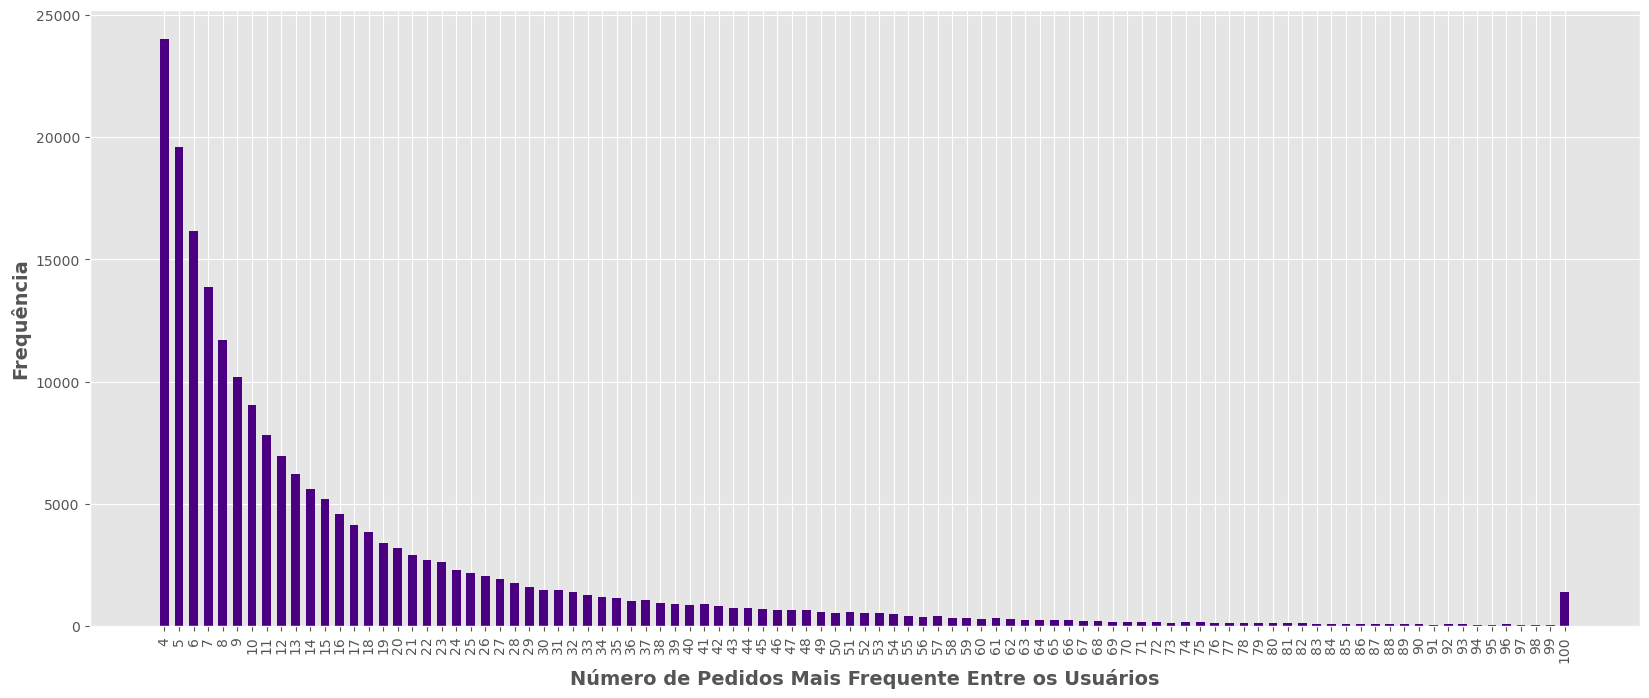

In [46]:
# Plot
plt.style.use('ggplot')
plt.figure(figsize = (20,8))
plt.bar(ord_max_count.index, ord_max_count.values, color = 'indigo', width = 0.6)
plt.xticks(ord_max_count.index, rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

## 2-Qual Dia da Semana Tem o Maior Numero de Pedidos?

In [47]:
# Frequências de pedidos por dia da semana (dow = day of the week)
x = [0,1,2,3,4,5,6]
y = [order[order['order_dow']==0].shape[0],
     order[order['order_dow']==1].shape[0],
     order[order['order_dow']==2].shape[0],
     order[order['order_dow']==3].shape[0],
     order[order['order_dow']==4].shape[0],
     order[order['order_dow']==5].shape[0],
     order[order['order_dow']==6].shape[0]]

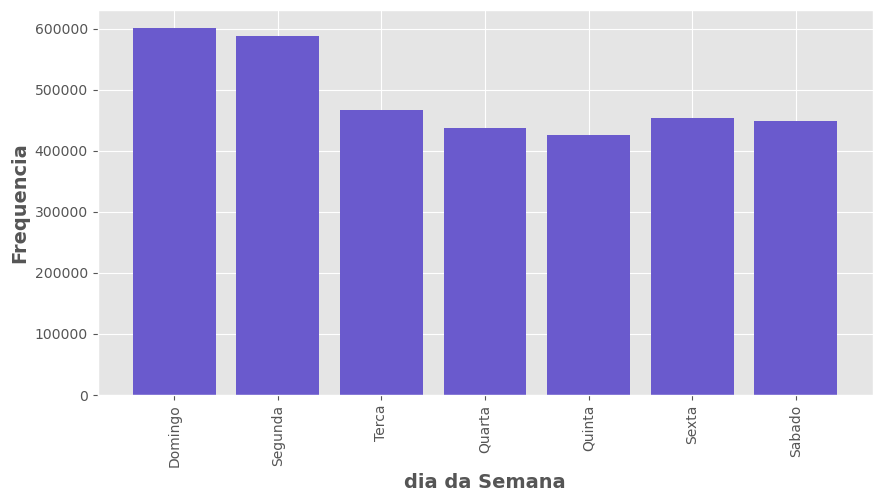

In [48]:
# Plot
plt.figure(figsize = (10,5))
plt.bar(x,y, color = 'slateblue')
plt.xlabel('dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequencia', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terca', 'Quarta', 'Quinta', 'Sexta', 'Sabado'], rotation = 'vertical')
plt.show()

# 3-Qual Hora do Dia Tem o Maior Numero de Pedidos?


In [49]:
# Frequencia de pedidos pela hora do dia
x = list(range(0,24))
y = []
for i in range(24):
    y.append(order[order['order_hour_of_day']==i].shape[0])

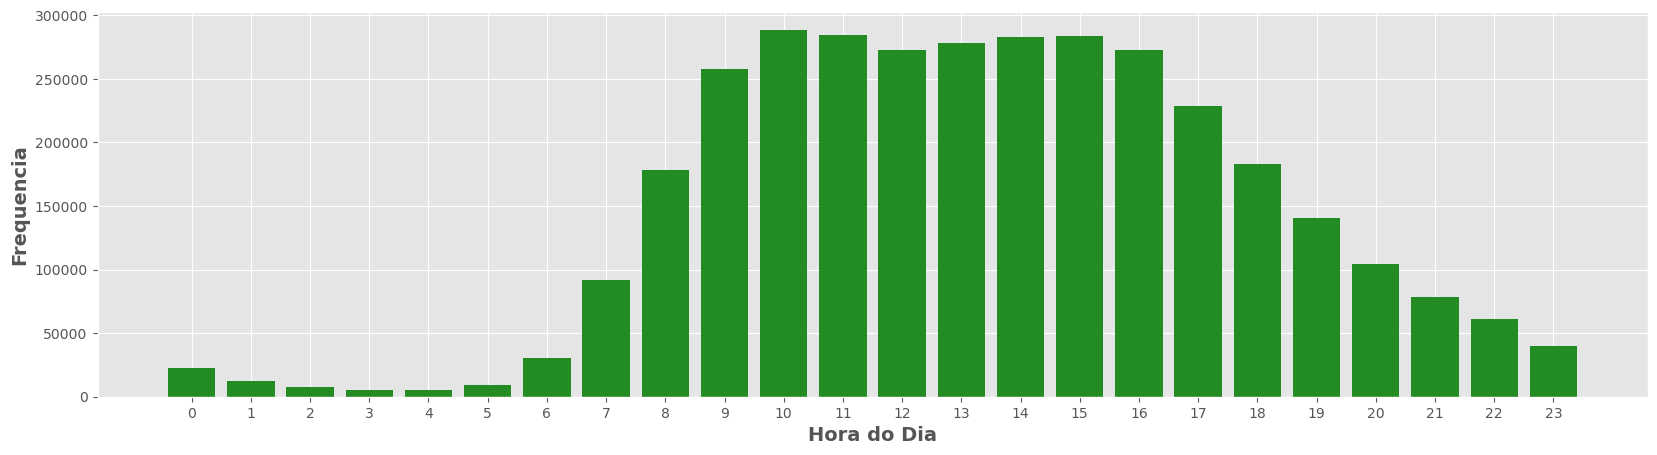

In [50]:
# Plot
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequencia', fontsize = 14, fontweight = 'bold')
plt.show()

## 4- Qual Departamento Tem o Maior Numero de Pedidos?

In [51]:
# Contagem de pedidos por departamento
dept_cnt = order_product_prior['department'].value_counts()

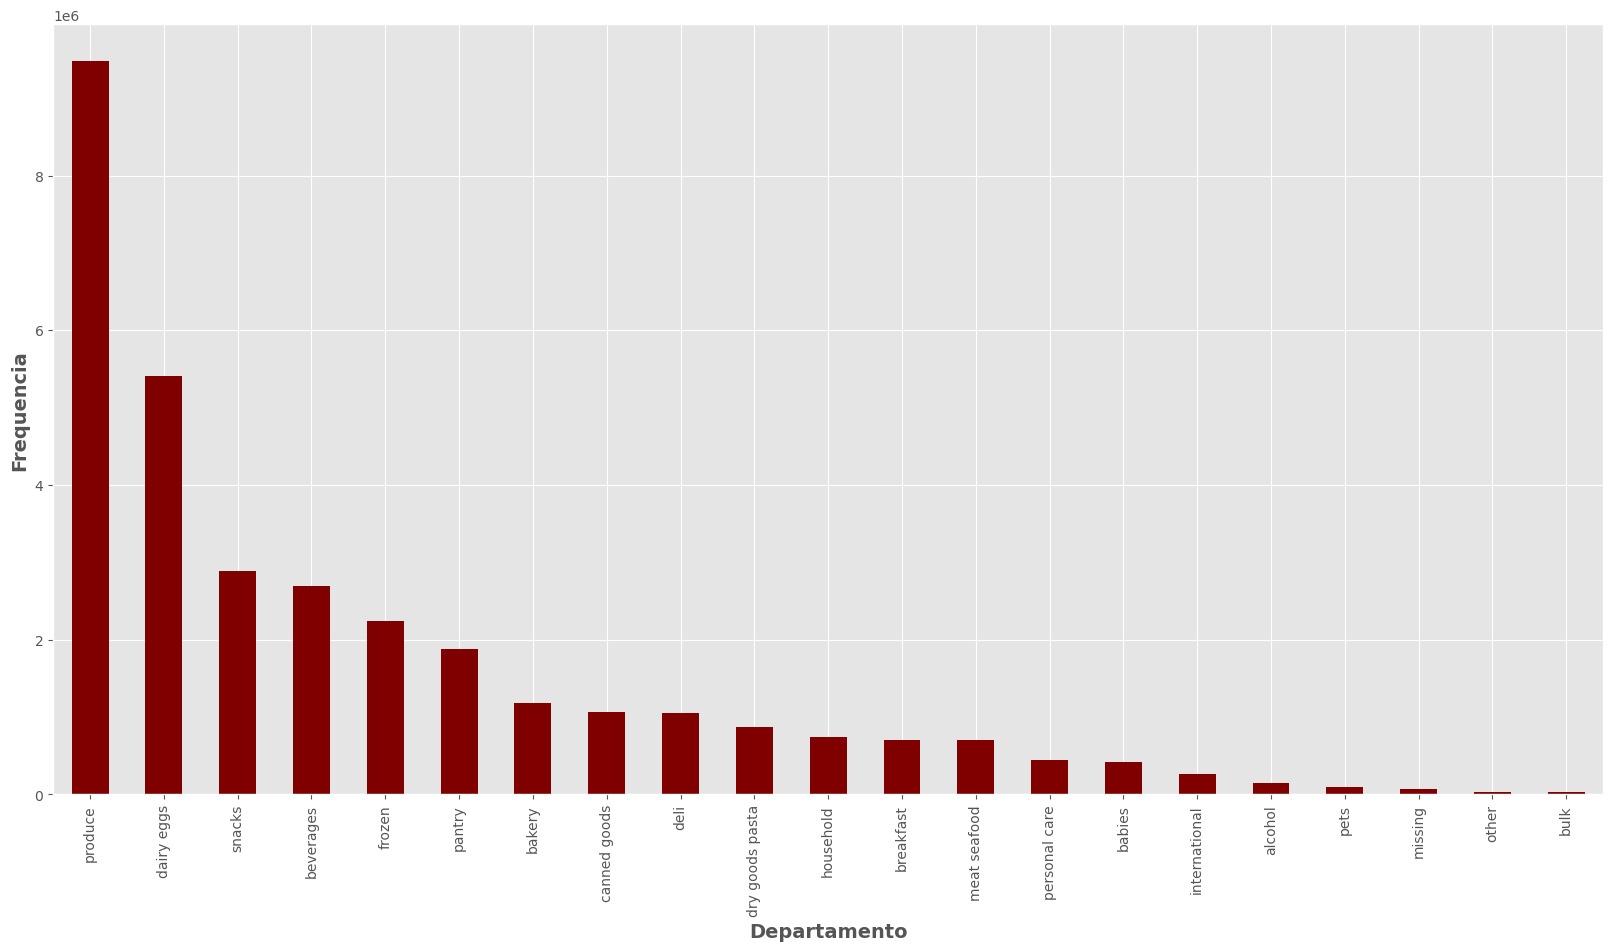

In [52]:
# Plot 
fig = plt.figure(figsize = (20,10))
dept_cnt.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departamento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequencia', fontsize = 14, fontweight = 'bold')
plt.show()

## 5 - Quais os 20 Principais Corredores Por Frequencia de Pedidos?

In [53]:
# OS 20 principais corredores e sua frequencia de pedidos
aisle_cnt = order_product_prior['aisle'].value_counts()

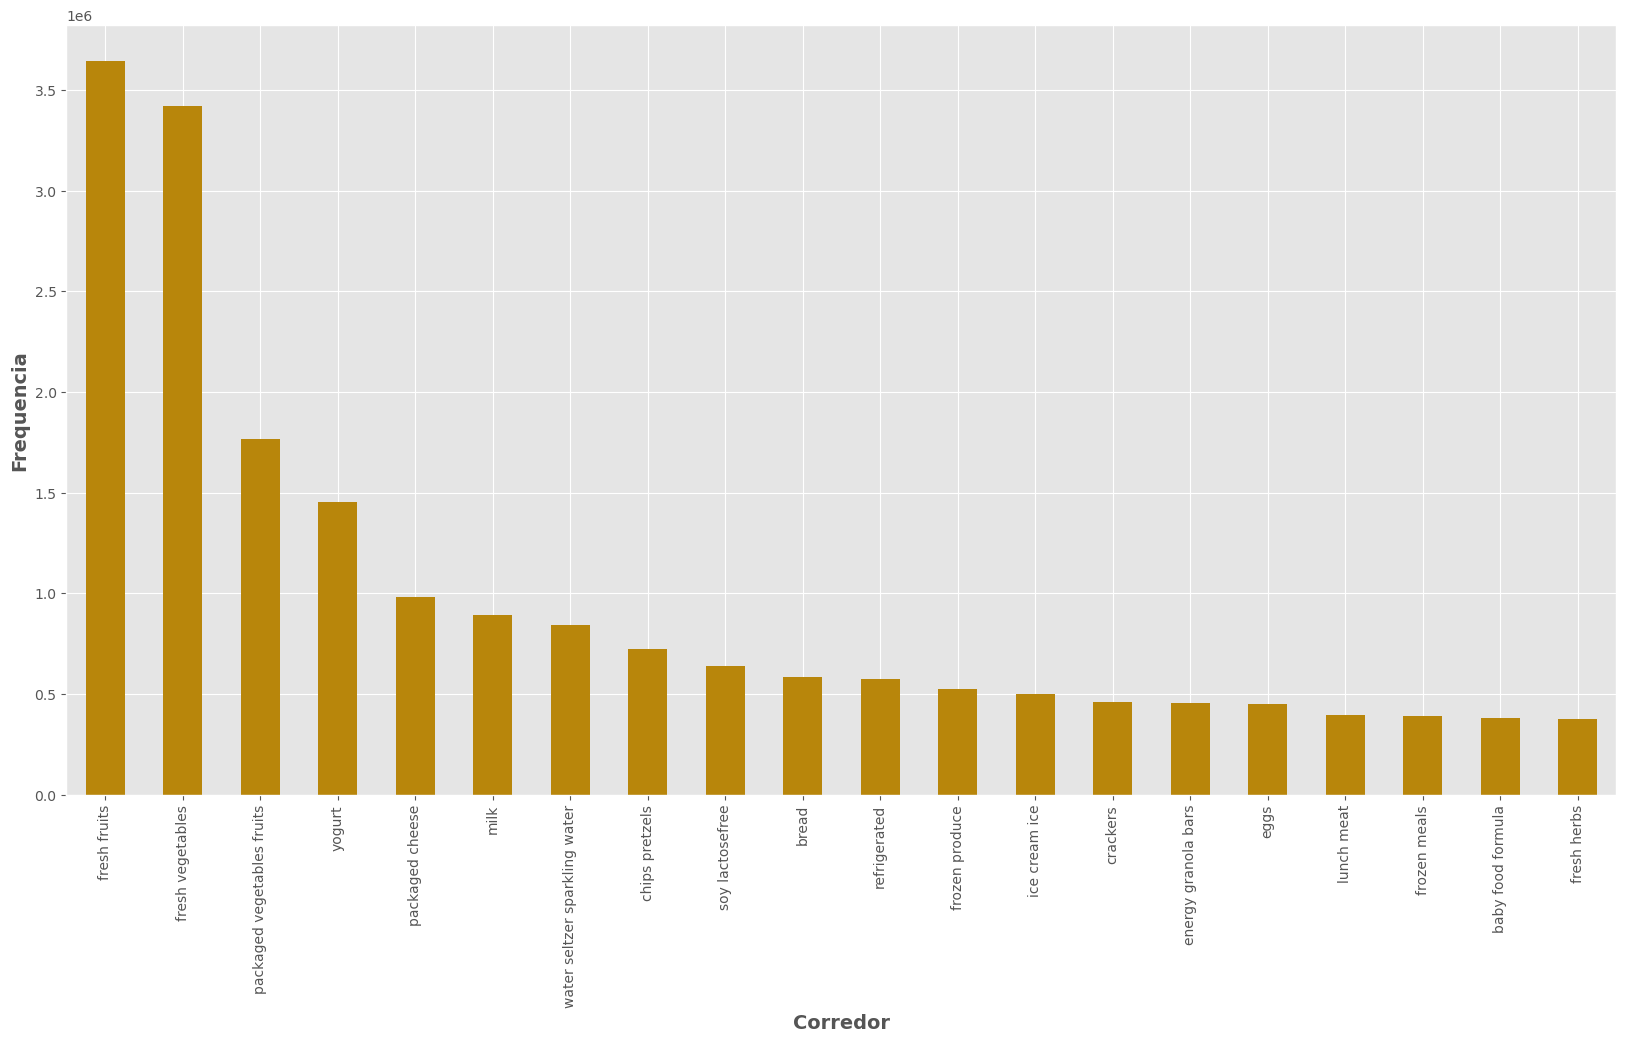

In [54]:
# Plot
fig = plt.figure(figsize = (20,10))
aisle_cnt[0:20].plot(kind = "bar", color = 'darkgoldenrod')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequencia', fontsize = 14, fontweight = 'bold')
plt.show()


## 6- Quais os 20 Principais Produtos Por Frequencia de Pedidos?

In [55]:
# OS 20 principais produtos por frequencia de pedido
prod_cnt = order_product_prior['product_name'].value_counts()

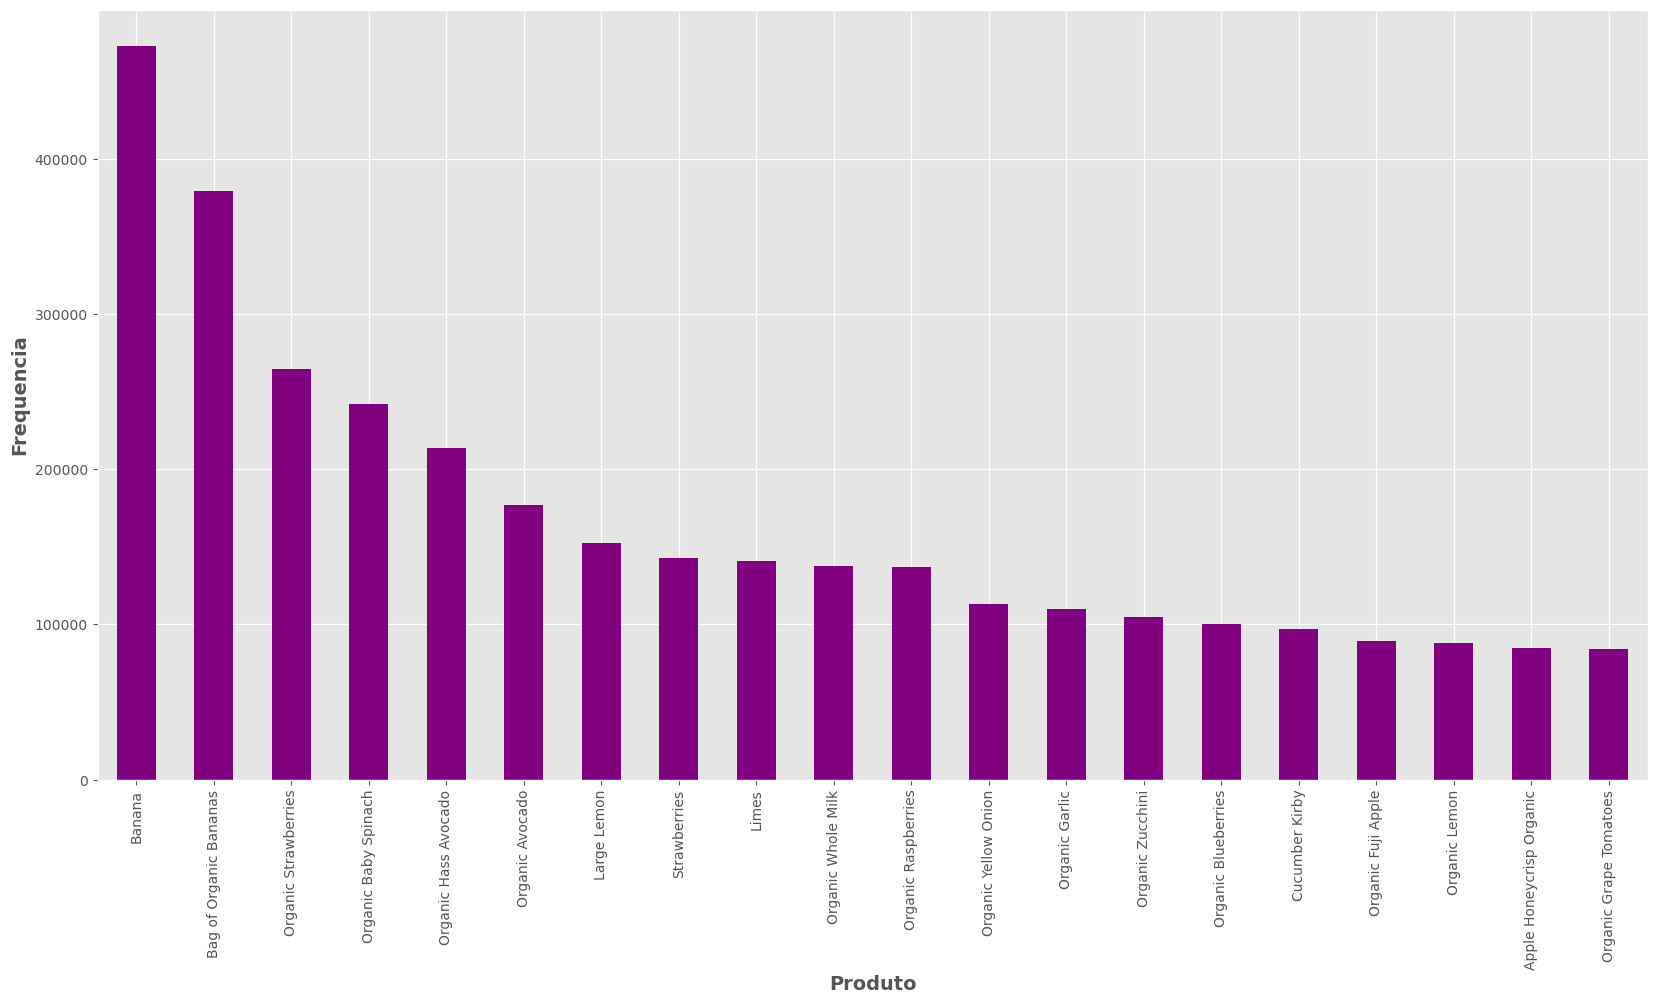

In [56]:
# Plot
fig = plt.figure(figsize = (20,10))
prod_cnt[0:20].plot(kind = "bar", color = "purple")
plt.xticks(rotation = 90)
plt.xlabel('Produto', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequencia', fontsize = 14, fontweight = 'bold')
plt.show()

## 7-Analise de Novos Pedidos Semelhantes a Pedidos Anteriores

In [57]:
%%time
temp_df = order_product_prior.groupby("product_name")["reordered"].agg(['count', 'sum']).rename(columns = {'count': 'total','sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

Wall time: 6.69 s


In [58]:
# Prepara as listas
labels = list(temp_df.product_name[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

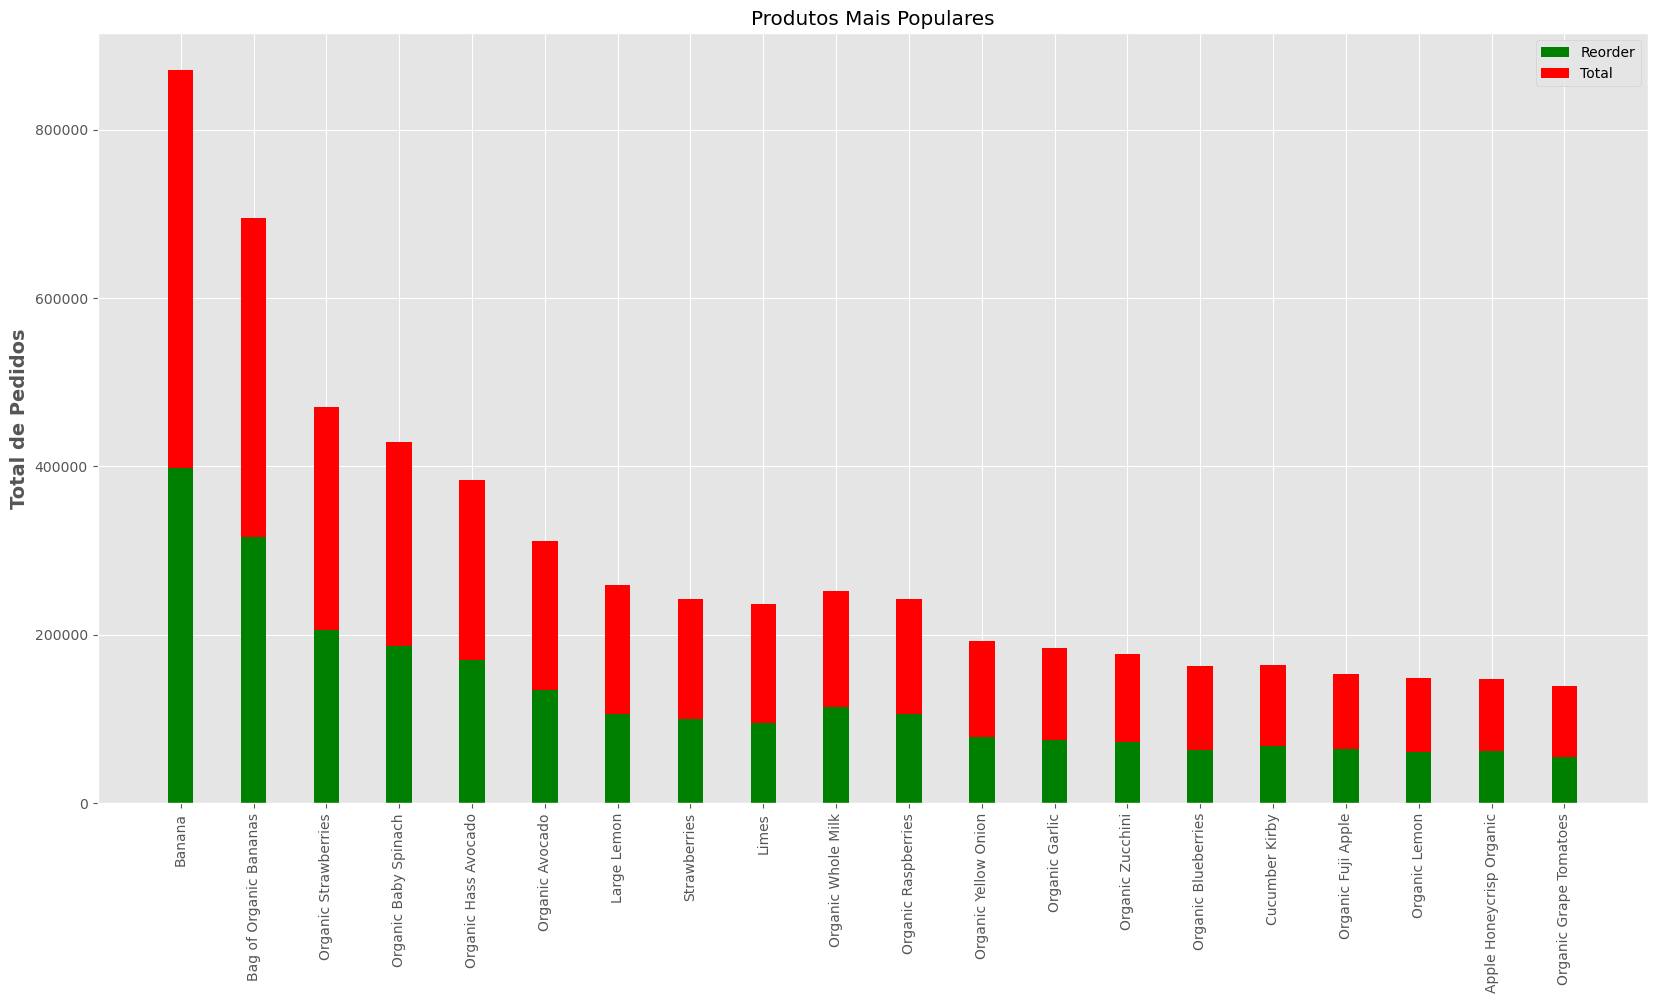

In [59]:
# Plot
width = 0.35
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares")
plt.xticks(rotation = 90)
plt.show()

## 8- Analise de Reorder Por Departamento ao Longo do Tempo

In [60]:
# Agrupando os dados por departamento e reorder
grouped_df = order_product_prior.groupby(["department"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922


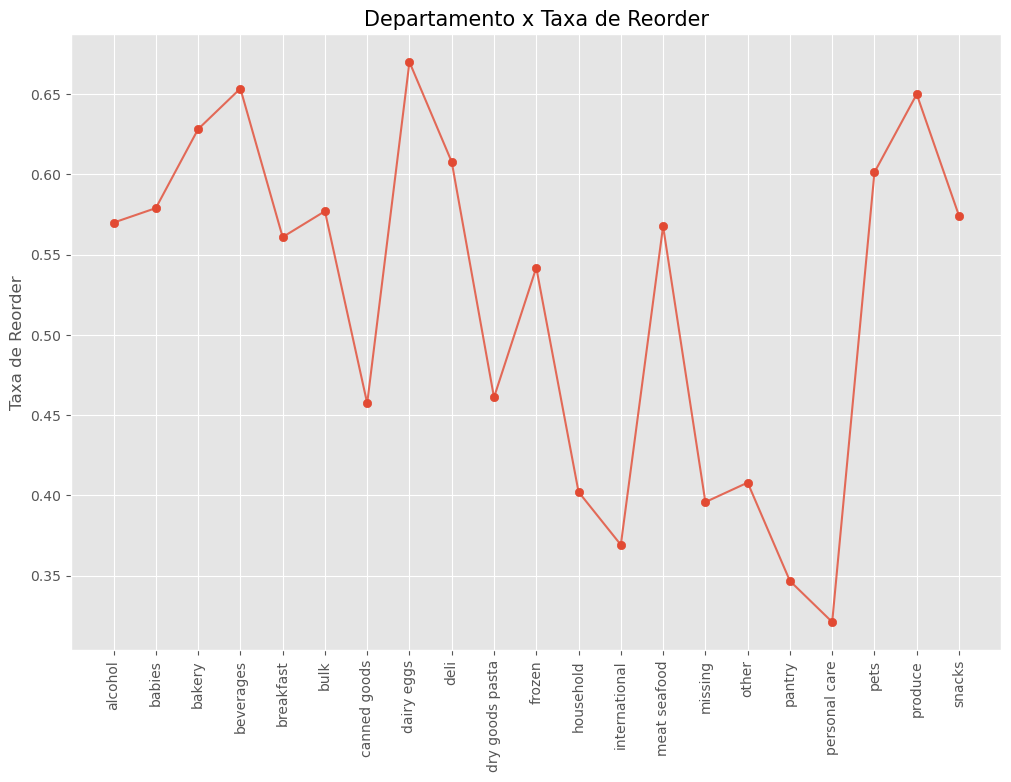

In [61]:
# Plot
plt.figure(figsize =(12,8))
plt.plot(list(grouped_df['department']), grouped_df['reordered'].values, alpha=0.8)
plt.scatter(list(grouped_df['department']), grouped_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.title("Departamento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

## 9-Analise de Reorder e Pedidos

In [62]:
%%time
temp_df = order_product_prior.groupby("department")["reordered"].agg(['count', 'sum']).rename(columns = {'count': 'total', 'sum': 'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

Wall time: 2.6 s


In [63]:
temp_df.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [65]:
# Listas
labels = list(temp_df.department[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

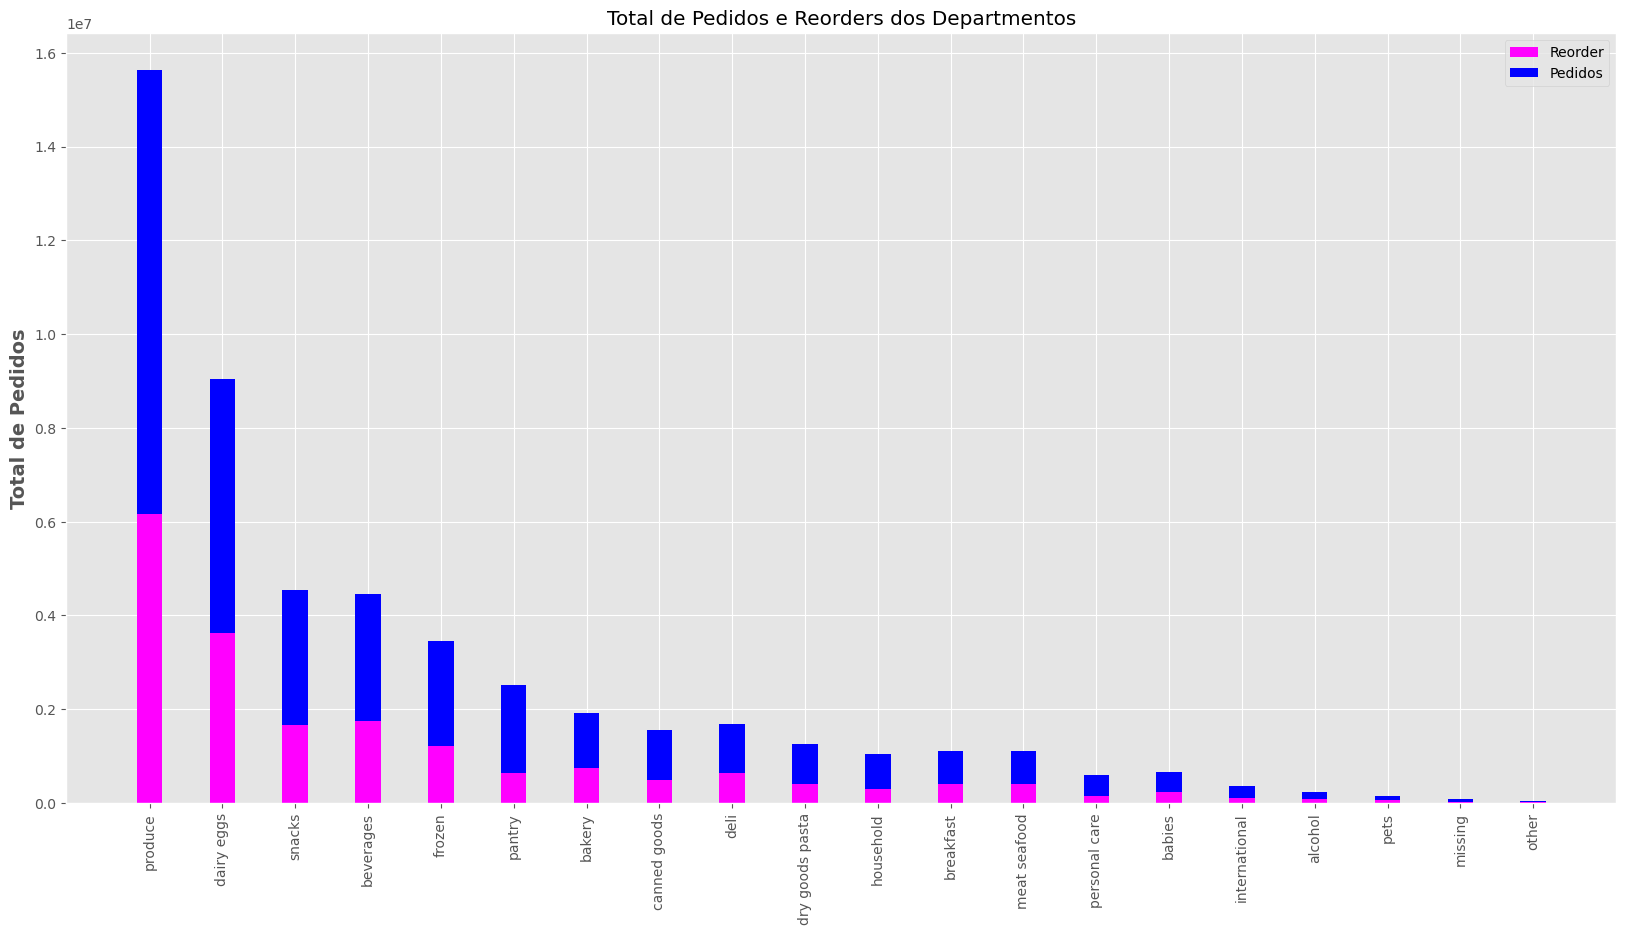

In [67]:
# Plot
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'magenta')
ax.bar(labels, total, width, bottom = reorder, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departmentos")
plt.xticks(rotation = 90)
plt.show()

## 10- Analise de Reorder Por Corredor

In [68]:
grouped_df = order_product_prior.groupby(["aisle"])["reordered"].aggregate("mean").reset_index()
grouped_df.head()

,aisle,reordered
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259


In [69]:
list(grouped_df['aisle'])[0:20]

['air fresheners candles',
 'asian foods',
 'baby accessories',
 'baby bath body care',
 'baby food formula',
 'bakery desserts',
 'baking ingredients',
 'baking supplies decor',
 'beauty',
 'beers coolers',
 'body lotions soap',
 'bread',
 'breakfast bakery',
 'breakfast bars pastries',
 'bulk dried fruits vegetables',
 'bulk grains rice dried goods',
 'buns rolls',
 'butter',
 'candy chocolate',
 'canned fruit applesauce']

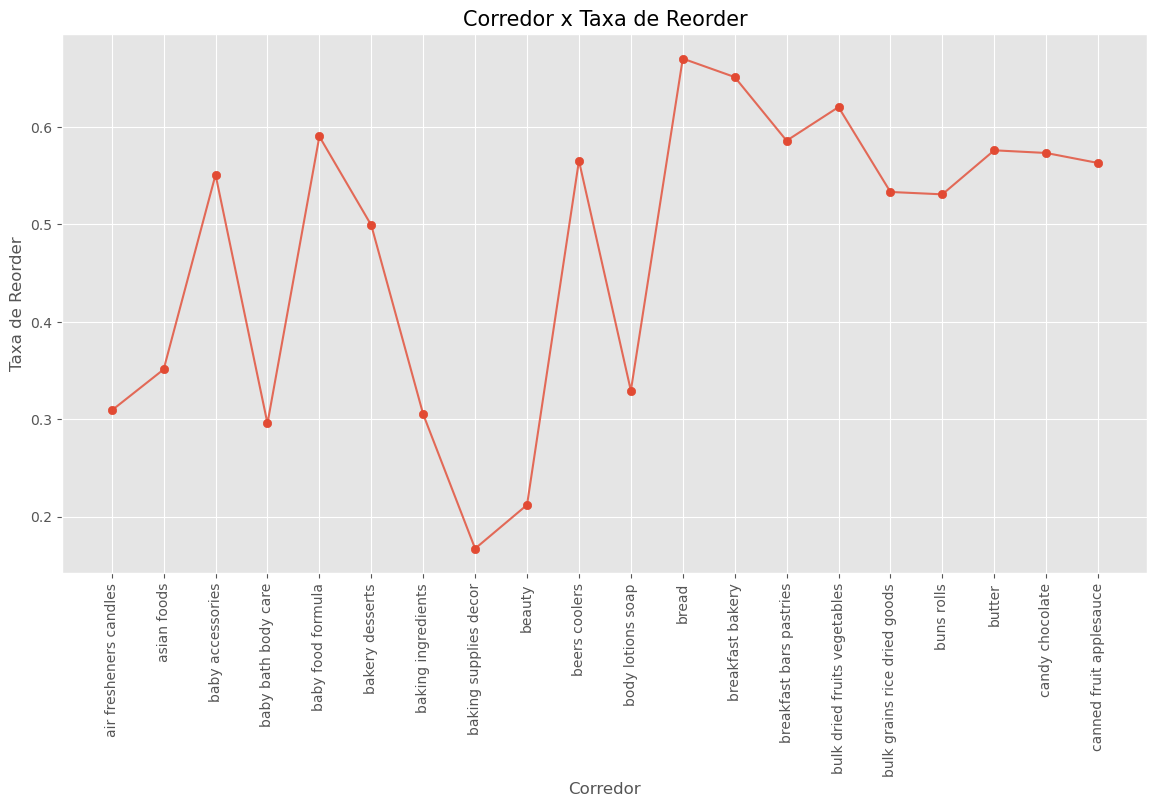

In [71]:
# Corredor x Taxa de Reorder
plt.figure(figsize=(14,7))
plt.plot(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20], alpha=0.8)
plt.scatter(list(grouped_df['aisle'])[0:20], grouped_df['reordered'].values[0:20])
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

## 11 - Analise de Reorder Por Corredor (Total)

In [72]:
%%time 
temp_df = order_product_prior.groupby("aisle")["reordered"].agg(['count', 'sum']).rename(columns = {'count' : 'total', 'sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

Wall time: 3.21 s


In [73]:
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [74]:
# Listas 
labels = list(temp_df.aisle[0:20])
reorder = list(temp_df.reorders[0:20])
total = list(temp_df.total[0:20])

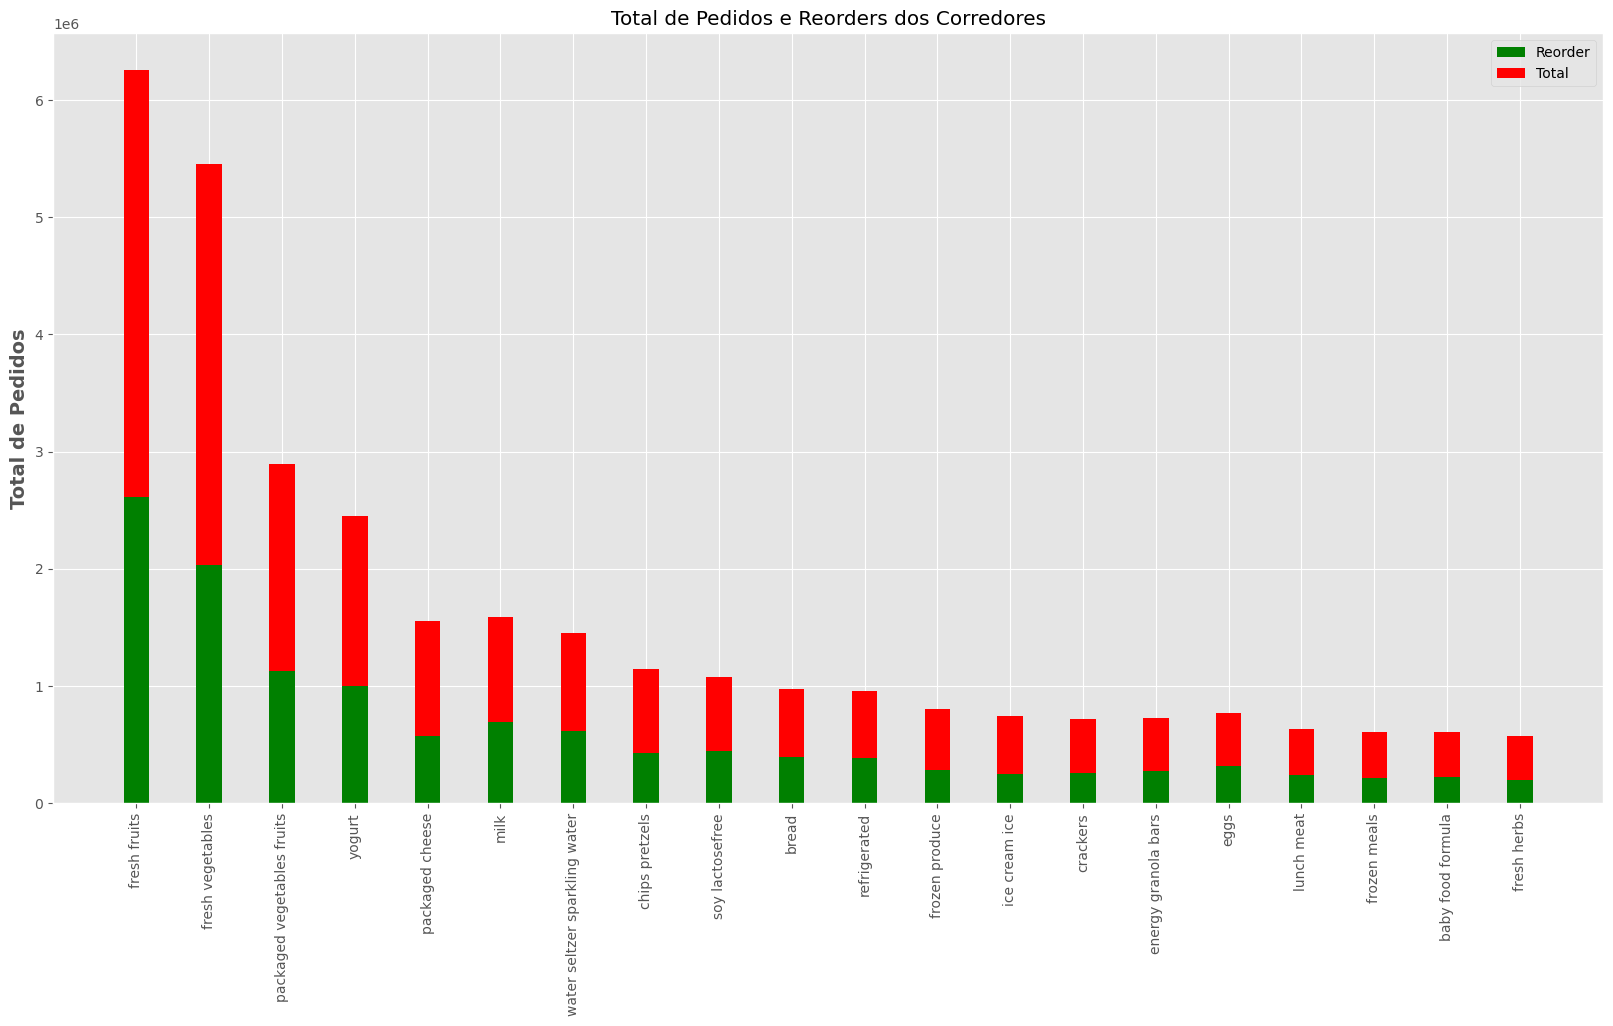

In [75]:
# Plot
width = 0.35
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(labels, reorder, width, label = 'Reorder', color = 'green')
ax.bar(labels, total, width, bottom = reorder, label = 'Total', color = 'red')
ax.set_ylabel("Total de Pedidos", fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredores")
plt.xticks(rotation = 90)
plt.show()